In [133]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import os
import time
import glob

In [134]:
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)

In [135]:
def quenc_resistor(slope, unc):
    rq = 1./slope
    unc_rq = 1./(slope*slope)*unc
    return rq, unc_rq

In [136]:
def MeasurementsSiPMs(folder='84_Cold'):
    # Specify the folder path
    folder_path = './data/'+folder+'/*'
    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
    #print(csv_files)
    #print(folder_path)

    # String to check for
    string_to_remove = "IV"

    # Remove elements containing the string
    filtered_list = [item for item in csv_files if string_to_remove not in item]

   
    rq_measuments = []
    df_append_rq = pd.DataFrame()
    SiPMs_labels_rq = []
    filtered_rq_list = [item for item in csv_files if 'rq' in item]
    
    #print(filtered_rq_list)
    for csv_file in filtered_rq_list: 
        #print(csv_file[53:-4])
        #print(csv_file)
        #SiPMs_labels_rq.append(csv_file[44:-14]+csv_file[61:-4])
        df = pd.read_csv(csv_file, skiprows=1,header=None)
        Voltage = np.array(df.iloc[:,1])
        Current = np.array(df.iloc[:,2])
        #print(Voltage)
        if folder == '84_Before':
            SiPMs_labels_rq.append(csv_file[48:-15]+csv_file[68:-4])
            Current = [Current[id] for id,x in enumerate(Voltage) if x > 0.75 and x < 1.25]
            Voltage = [x for x in Voltage if x > 0.75 and x < 1.25]
        else:
            SiPMs_labels_rq.append(csv_file[44:-14]+csv_file[61:-4])
            Current = [Current[id] for id,x in enumerate(Voltage) if x > 1.5 and x <2.5]
            Voltage = [x for x in Voltage if x > 1.5 and x <2.5]
              
        # Perform linear regression
        result = linregress(Voltage, Current)
        rq_measuments.append(quenc_resistor(result.slope,result.stderr))

        slope = np.array(result.slope)

        plt.figure(dpi=150)
        plt.scatter(Voltage, Current, label='Measument')
        plt.plot(Voltage,slope * Voltage + result.intercept, color='red', label='Fit')
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.legend(title = rf'p0 = {round(result.intercept,4)}$\pm$ {round(result.intercept_stderr,6)}, p1 = {round(result.slope,5)}$\pm$ {round(result.stderr,7)}')
        plt.savefig(csv_file[:-4]+'_fit_rq.pdf', dpi = 150, format = 'pdf')
        plt.close()
        
    #print(SiPMs_labels_rq)    
    # Save the data columns in a CSV file
    rq_measuments = np.array(rq_measuments)
    #print(rq_measuments)
    df_append_rq = pd.DataFrame({
    'SiPM Label Rq':SiPMs_labels_rq,
    'Rq': rq_measuments[:,0],
    'Std_Rq': rq_measuments[:,1],
    })
    
    #df_append_rq = pd.concat([df_append_rq,data], ignore_index=True)
    
    filtered_vbd_list = [item for item in filtered_list if 'rq' not in item]
    # Sort by the last character of each string
    sorted_list = sorted(filtered_vbd_list, key=lambda x: x[-9])
    #print(sorted_list)
    
    df_append_vbd = pd.DataFrame()
    
    df_append_vbd = [pd.read_csv(csv_file, header=None) for csv_file in sorted_list]
    
    df_append_vbd = pd.concat(df_append_vbd, ignore_index=True) 
    df_append_vbd.columns = ['SiPM Label Vbd', 'Vbd']
    
    # Sort the DataFrame by the end of the string in column 'A'
    df_append_vbd['sort_key'] = df_append_vbd['SiPM Label Vbd'].apply(lambda x: x[::-1])
    df_sorted_vbd = df_append_vbd.sort_values(by='sort_key', ascending=True).drop(columns='sort_key')
    # Reset the index and drop the old index
    df_sorted_vbd = df_sorted_vbd.reset_index(drop=True)
    
    
    #df_append_vbd = df_append_vbd.reset_index(drop=True)
    #print(df_append_vbd)
    # Sort the DataFrame by the end of the string in column 'A'
    df_append_rq['sort_key'] = df_append_rq['SiPM Label Rq'].apply(lambda x: x[::-1])
    df_sorted = df_append_rq.sort_values(by='sort_key', ascending=True).drop(columns='sort_key')
    # Reset the index and drop the old index
    df_sorted = df_sorted.reset_index(drop=True)
    
    df_sorted = pd.concat([df_sorted, df_sorted_vbd], axis=1)
    
        
        
    return df_sorted
    

In [137]:
cold = MeasurementsSiPMs(folder='84_Cold')
cold = cold.drop(index=[22,28,34,40,43,44,46,49,50,52])

room = MeasurementsSiPMs(folder='84_Before')
room = room.drop(index=[22,28,34,40,43,44,46,49,50,52])

In [138]:
cold
cold.to_csv('SiPMsMeasurements_Cold.csv', index=False)

In [139]:
room
room.to_csv('SiPMsMeasurements_Room.csv', index=False)

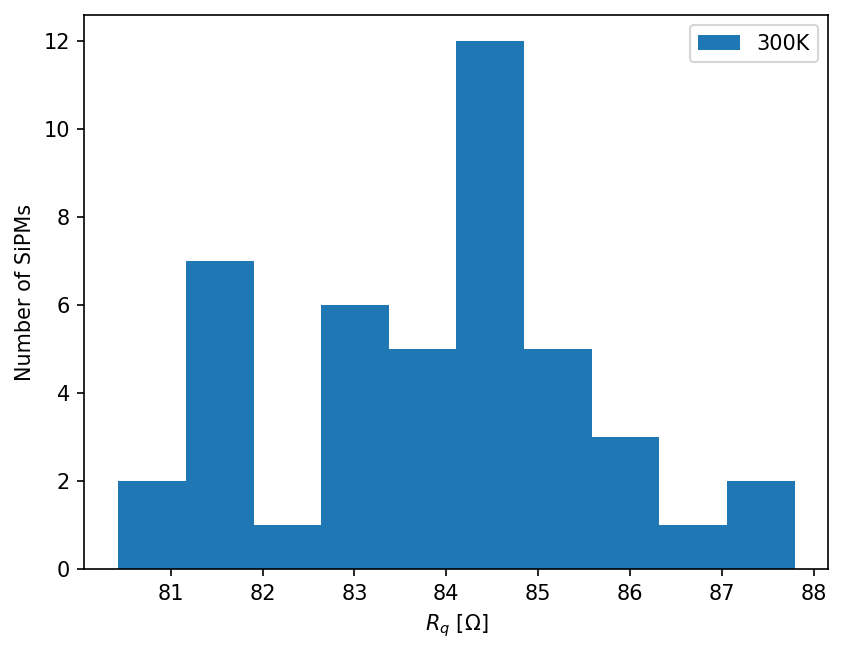

In [140]:
plt.figure(dpi=150)
plt.hist(room.iloc[:,1], label= r'300K')
plt.xlabel(r'$R_q$ [$\Omega$]')
plt.ylabel('Number of SiPMs')
plt.legend()
plt.show()

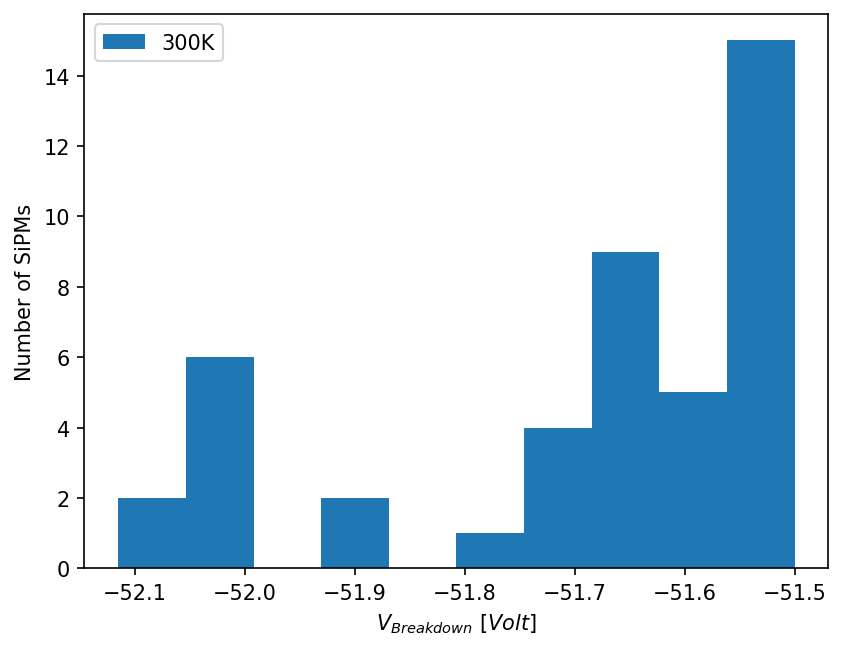

In [141]:
plt.figure(dpi=150)
plt.hist(room.iloc[:,4], label= r'300K')
plt.xlabel(r'$V_{Breakdown}$ [$Volt$]')
plt.ylabel('Number of SiPMs')
plt.legend()
plt.show()

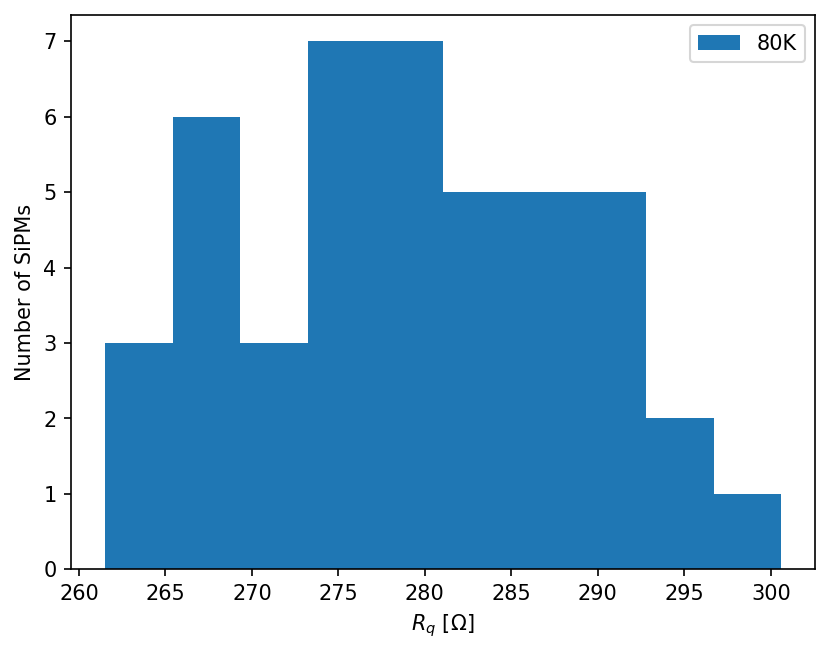

In [142]:
plt.figure(dpi=150)
plt.hist(cold.iloc[:,1], label= r'80K')
plt.xlabel(r'$R_q$ [$\Omega$]')
plt.ylabel('Number of SiPMs')
plt.legend()
plt.show()

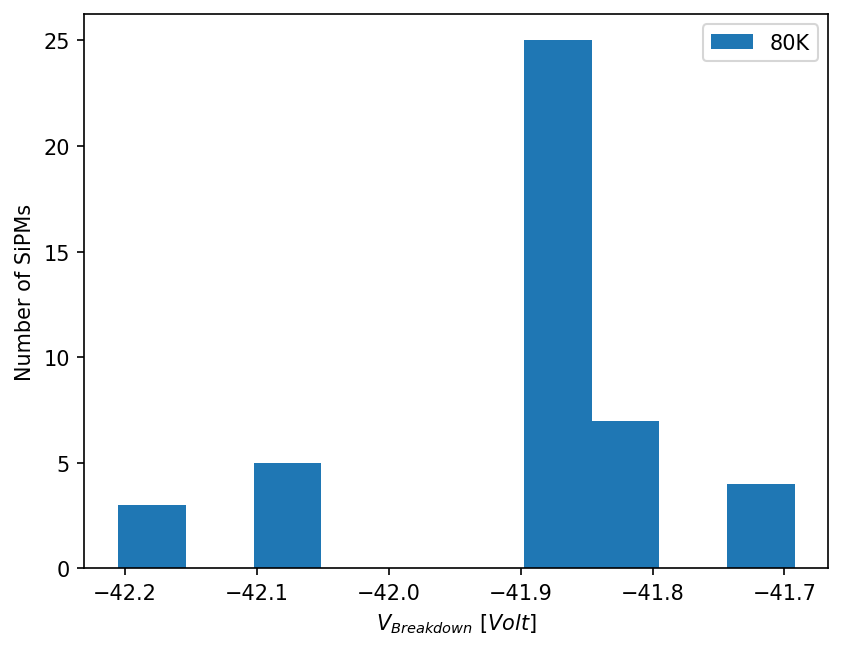

In [143]:
plt.figure(dpi=150)
plt.hist(cold.iloc[:,4], label= r'80K')
plt.xlabel(r'$V_{Breakdown}$ [$Volt$]')
plt.ylabel('Number of SiPMs')
plt.legend()
plt.show()